# imports

In [21]:
import pandas as pd
import numpy as np
import joblib
import warnings
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    precision_recall_curve,
)
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
DATA_PATH = "data/heart_attack_prediction_indonesia.csv"
TARGET_COLUMN = "heart_attack"
RANDOM_STATE = 42

NUMERIC_FEATURES = [
    "age",
    "cholesterol_level",
    "waist_circumference",
    "sleep_hours",
    "blood_pressure_systolic",
    "blood_pressure_diastolic",
    "fasting_blood_sugar",
    "cholesterol_hdl",
    "cholesterol_ldl",
    "triglycerides",
]

CATEGORICAL_FEATURES = [
    "gender",
    "region",
    "income_level",
    "smoking_status",
    "alcohol_consumption",
    "physical_activity",
    "dietary_habits",
    "air_pollution_exposure",
    "stress_level",
    "EKG_results",
]

BINARY_PASSTHROUGH_FEATURES = [
    "hypertension",
    "diabetes",
    "obesity",
    "family_history",
    "previous_heart_disease",
    "medication_usage",
    "participated_in_free_screening",
]


# Load & Clean Data

In [3]:
def handle_outliers_capping(dataframe, columns):
    df_capped = dataframe.copy()
    for col in columns:
        lower_bound = df_capped[col].quantile(0.01)
        upper_bound = df_capped[col].quantile(0.99)
        df_capped[col] = np.clip(df_capped[col], lower_bound, upper_bound)
    return df_capped

In [4]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    # Convert numeric columns
    for col in NUMERIC_FEATURES:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Convert binary columns
    binary_cols = BINARY_PASSTHROUGH_FEATURES + [TARGET_COLUMN]
    for col in binary_cols:
        df[col] = df[col].astype(int)

    # Handle missing categorical
    df["alcohol_consumption"] = df["alcohol_consumption"].fillna(
        df["alcohol_consumption"].mode()[0]
    )

    # APPLY OUTLIER CAPPING
    df = handle_outliers_capping(df, NUMERIC_FEATURES)

    print(f"Data loaded with shape: {df.shape}")
    print(f"Target distribution:\n{df[TARGET_COLUMN].value_counts()}")
    return df

data = load_and_clean_data(DATA_PATH)


Data loaded with shape: (158355, 28)
Target distribution:
heart_attack
0    94854
1    63501
Name: count, dtype: int64


# Preprocessor

In [5]:
def create_preprocessor():
    numeric_transformer = Pipeline([("scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        [("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_FEATURES),
            ("cat", categorical_transformer, CATEGORICAL_FEATURES),
            ("bin", "passthrough", BINARY_PASSTHROUGH_FEATURES),
        ]
    )
    return preprocessor


preprocessor = create_preprocessor()


# Split + SMOTE Preprocessing

In [6]:
def split_and_resample_data(df):
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    smote = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

    print("SMOTE done:", X_resampled.shape)
    return X_resampled, X_test_transformed, y_resampled, y_test


X_train_resampled, X_test_transformed, y_train_resampled, y_test = split_and_resample_data(data)


SMOTE done: (151766, 42)


# Evaluation Functions

In [7]:
def evaluate_model_performance(y_true, y_pred, y_proba):
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred),
    }


def find_best_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    idx = np.argmax(f1_scores)
    return thresholds[idx], f1_scores[idx]


# Cross Validation

In [8]:
def run_cross_validation(models, X_train, y_train):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

    results = []

    for name, model in models.items():
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=kfold, scoring=roc_auc_scorer, n_jobs=-1
        )
        results.append([name, cv_scores.mean(), cv_scores.std()])

    return pd.DataFrame(results, columns=["Model", "Mean ROC-AUC", "Std ROC-AUC"])


models = {
    "Logistic Regression": LogisticRegression(solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

cv_results_df = run_cross_validation(models, X_train_resampled, y_train_resampled)
cv_results_df


,Model,Mean ROC-AUC,Std ROC-AUC
0,Logistic Regression,NaN,NaN
1,Decision Tree,NaN,NaN
2,KNN,NaN,NaN
3,Random Forest,NaN,NaN
4,Gradient Boosting,NaN,NaN


# Random Forest Tuning

In [9]:
def tune_random_forest(X_train, y_train):
    X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train, train_size=0.2, stratify=y_train, random_state=RANDOM_STATE
    )

    param_dist = {
        "n_estimators": randint(50, 200),
        "max_depth": [5, 10, 20, None],
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", 0.5, 0.75]
    }

    rf = RandomForestClassifier()

    search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=20,
        scoring="f1",
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_sample, y_sample)
    return search.best_estimator_


best_model_name = cv_results_df.iloc[0]["Model"]

if best_model_name == "Random Forest":
    final_model = tune_random_forest(X_train_resampled, y_train_resampled)
else:
    final_model = models[best_model_name].fit(X_train_resampled, y_train_resampled)


# Final Evaluation

In [13]:
y_proba = final_model.predict_proba(X_test_transformed)[:, 1]
best_threshold, best_f1 = find_best_threshold(y_test, y_proba)

print("Best threshold:", best_threshold, " | F1:", best_f1)

y_pred = (y_proba >= best_threshold).astype(int)
metrics = evaluate_model_performance(y_test, y_pred, y_proba)

metrics

Best threshold: 0.40258106816736033  | F1: 0.6773216080114713


{'roc_auc': 0.7996121265902328,
 'accuracy': 0.6940102933282813,
 'precision': 0.5867997461489644,
 'recall': 0.8008661417322834,
 'f1_score': 0.6773216128924849,
 'confusion_matrix': array([[11809,  7162],
        [ 2529, 10171]]),
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.82      0.62      0.71     18971\n           1       0.59      0.80      0.68     12700\n\n    accuracy                           0.69     31671\n   macro avg       0.71      0.71      0.69     31671\nweighted avg       0.73      0.69      0.70     31671\n'}

# Feature Importance & Visualization

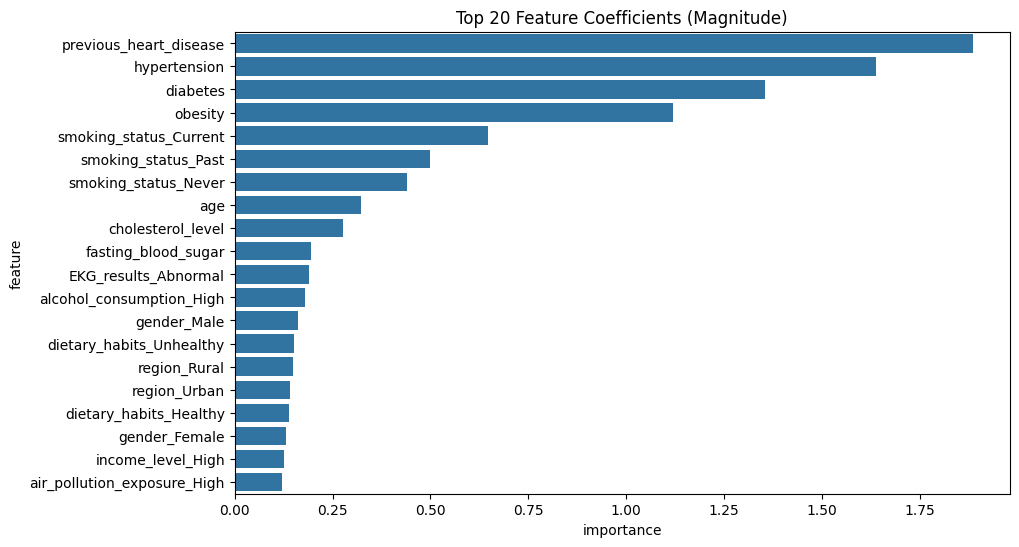

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
coeffs = final_model.coef_[0]
feature_names = NUMERIC_FEATURES + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)) + BINARY_PASSTHROUGH_FEATURES

feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': np.abs(coeffs)})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title("Top 20 Feature Coefficients (Magnitude)")
plt.show()


# ROC and Precision-Recall Curves

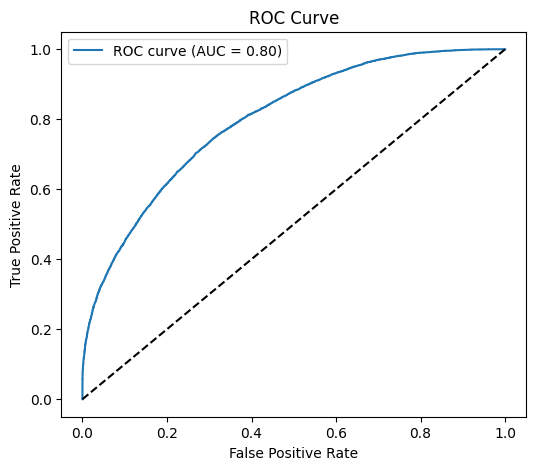

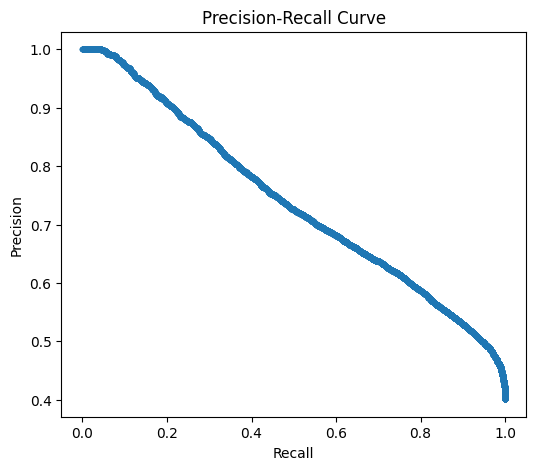

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [11]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", final_model)
])

joblib.dump(full_pipeline, "full_model_pipeline.joblib")

['full_model_pipeline.joblib']

# Save pipeline

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(full_pipeline, f"full_model_pipeline_{timestamp}.joblib")

['full_model_pipeline_20251130_001241.joblib']

# Deployment

In [32]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import threading

# Load model
full_pipeline = joblib.load("full_model_pipeline_20251130_001241.joblib")

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame(data)
    preds = full_pipeline.predict(df)
    probs = full_pipeline.predict_proba(df)[:, 1]
    return jsonify({'predictions': preds.tolist(), 'probabilities': probs.tolist()})

# Run Flask in a separate thread
def run_flask():
    app.run(host="0.0.0.0", port=5000, debug=False, use_reloader=False)

thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [33]:
import requests

url = "http://127.0.0.1:5000/predict"  # your local Flask API

data = [
    {
        "age": 55,
        "cholesterol_level": 200,
        "waist_circumference": 90,
        "sleep_hours": 6,
        "blood_pressure_systolic": 130,
        "blood_pressure_diastolic": 85,
        "fasting_blood_sugar": 100,
        "cholesterol_hdl": 50,
        "cholesterol_ldl": 120,
        "triglycerides": 150,
        "gender": "male",
        "region": "urban",
        "income_level": "medium",
        "smoking_status": "never",
        "alcohol_consumption": "moderate",
        "physical_activity": "low",
        "dietary_habits": "balanced",
        "air_pollution_exposure": "high",
        "stress_level": "medium",
        "EKG_results": "normal",
        "hypertension": 0,
        "diabetes": 0,
        "obesity": 0,
        "family_history": 1,
        "previous_heart_disease": 0,
        "medication_usage": 0,
        "participated_in_free_screening": 1
    }
]

response = requests.post(url, json=data)
print(response.json())


{'predictions': [0], 'probabilities': [0.40529679829334636]}
